# Contents

### 1. A1111 Webui Benchmark data preparation and analysis

- Load Automatic1111 webui benchmark data 
- Narrow down relevant columns
- Visualize the distribution of the dates of the benchmarks (histogram)
- Extract individual scores from scores column
- Extract GPU model and RAM
- Remove worst performing GPUs by selecting bottom 20, then dropping them to narrow scope.
- Remove specific GPU references with str.contains to narrow scope to AMD and Nvidia consumer GPUs.
- Remove additional GPUs using a manually generated blacklist (remove non-consumer grade GPUs).

### 2. A1111 Webui Benchmark data visualization

- Data visualizations for 

    - Average performance across benchmarks from the maximum score per benchmark
    - Maximum performance across benchmarks from the maximum score per benchmark

### 3. Analysis for performance vs price

- Load price data and visualize price per GPU
- Merge price and benchmarks to get performance / price ratio.
- Visualize performance to price ratio per GPU with color scale based off price.
- Visualize iterations per second per GPU with color scale based off price.
- Visualize seconds to generate an 512x512 image with 25 steps with color scale based off price.

### 4. References to work by other authors

### 5.Conclusions

***

**Disclaimer.** Please note that price data was gathered manually by using Amazon prices as reference on July 16, 2023. These prices are constantly changing, therefore, other analysis may show slightly different results.

Import required libraries

In [339]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_theme(style="darkgrid")

pd.set_option('display.max_rows', 100)

pd.options.plotting.backend = "matplotlib"
pd.options.mode.chained_assignment = None  # default='warn'

Import available GPU benchmark data from .json

In [340]:
with open(r".\benchmark-raw-july.json", encoding="utf-8") as datafile:
    data = json.load(datafile)

In [341]:
df = pd.DataFrame(data['events'])
df.head()

,id,program,message,generated_at,source_id
0,1564370541899603981,SDBENCHMARK,vlado 2023-02-20 11:56:43.428913|7.2 / 8.1 / 8...,2023-02-20T06:57:04-05:00,13744943742
1,1564384811064422401,SDBENCHMARK,lee 2023-02-20 12:53:35.026828|12.99 / 15.54 /...,2023-02-20T07:53:45-05:00,13745046228
2,1564410893817790468,SDBENCHMARK,bruno 2023-02-20 10:22:36.948038|6.71 / 7.57 /...,2023-02-20T11:37:24-05:00,13745116355
3,1564410893842956294,SDBENCHMARK,bruno 2023-02-20 16:36:33.100836|6.6 / 7.55 / ...,2023-02-20T11:37:24-05:00,13745116355
4,1564413446202769420,SDBENCHMARK,Eljoseto 2023-02-19 13:10:54.164023|5.8 / 6.71...,2023-02-20T11:47:33-05:00,13745122479


Get a DataFrame directly from the json data, drop irrelevant columns

- message (in csv form), expand then drop original
- program
- id (irrelevant UUID)
- source_id

In [342]:
df.drop(columns=["program","id","source_id"], inplace=True)

In [343]:
# Create a DataFrame from the parsed data. Faster than looping and deleting manually.
expanded = df['message'].str.split('|', expand=True)
expanded.loc[:,9].unique()[:5]


array(['', 'test', 'Test2', 'GPU offset: +150 MHz; VRAM offset: +2000MHz',
       'w/ medvram'], dtype=object)

In [344]:
expanded.columns = ["timestamp","scores","sdver","sysinfo","torch","gpu", "xformers","model","user","comments","val1","val2","val3"]
expanded = expanded[["scores","sdver","sysinfo","torch","gpu", "xformers","model","comments","user"]]

df.drop(columns=["message"], inplace=True)
result = pd.concat([df, expanded], axis=1)
result.head(1)

,generated_at,scores,sdver,sysinfo,torch,gpu,xformers,model,comments,user
0,2023-02-20T06:57:04-05:00,7.2 / 8.1 / 8.84,updated:2023-02-19 hash:fc3e9e5d url:https://g...,host:wsl arch:x86_64 cpu:x86_64 system:Linux r...,torch:2.0.0.dev20230211+cu118 autocast half xf...,"device:NVIDIA GeForce RTX 3060 (1) (sm_90) (8,...",xformers none,sd-v15-runwayml.ckpt [cc6cb27103],,vlado


In [345]:
result.info()
result.generated_at[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   generated_at  10683 non-null  object
 1   scores        10683 non-null  object
 2   sdver         10683 non-null  object
 3   sysinfo       10683 non-null  object
 4   torch         10683 non-null  object
 5   gpu           10683 non-null  object
 6   xformers      10683 non-null  object
 7   model         10683 non-null  object
 8   comments      10683 non-null  object
 9   user          10683 non-null  object
dtypes: object(10)
memory usage: 834.7+ KB


'2023-02-20T06:57:04-05:00'

In [346]:
result.generated_at = pd.to_datetime(result.generated_at).apply(lambda x: x.date())
result.generated_at[0]

datetime.date(2023, 2, 20)

Check how recent the data is to gauge how relevant the results will be.

As SD is constantly in development, older benchmarks may not provide a full understanding of gpu performance

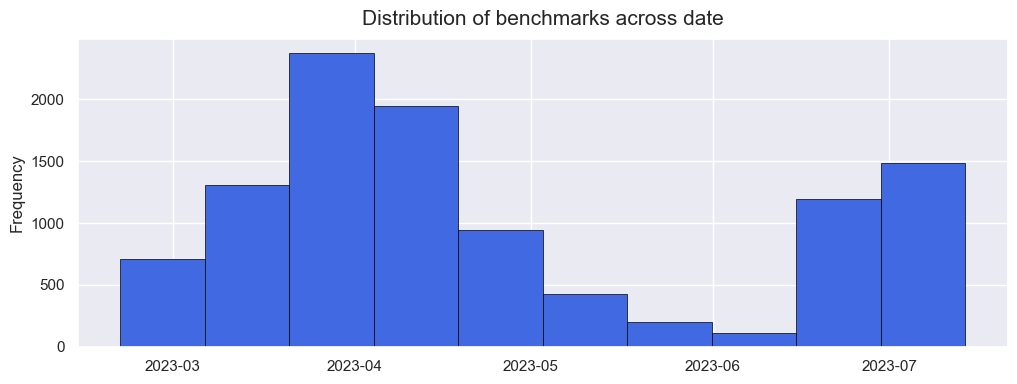

In [347]:
plt.figure(figsize=(12, 4))
ax = result.generated_at.hist(grid=True, facecolor = 'royalblue', edgecolor='#000000', linewidth=0.5, density=False)
ax.set_title("Distribution of benchmarks across date", size = 15, pad = 10)
ax.set_ylabel("Frequency")
plt.show()

Expand results column into individual columns

In [348]:
# Extract benchmark scores from the message field
scores = result['scores'].str.split(' / ', expand=True).apply(pd.to_numeric, errors="coerce")
result.drop(columns=["scores"], inplace=True)
scores.columns = [f'score_{i+1}' for i in range(scores.shape[1])]
# Calculate the mean benchmark score for each row
scores['best_score'] = scores.max(axis=1) 
scores['mean_score'] = scores.mean(axis=1) 
result = pd.concat([result, scores], axis=1)
result.head(1)

,generated_at,sdver,sysinfo,torch,gpu,xformers,model,comments,user,score_1,score_2,score_3,score_4,score_5,best_score,mean_score
0,2023-02-20,updated:2023-02-19 hash:fc3e9e5d url:https://g...,host:wsl arch:x86_64 cpu:x86_64 system:Linux r...,torch:2.0.0.dev20230211+cu118 autocast half xf...,"device:NVIDIA GeForce RTX 3060 (1) (sm_90) (8,...",xformers none,sd-v15-runwayml.ckpt [cc6cb27103],,vlado,7.2,8.1,8.84,NaN,NaN,8.84,8.245


Extract the graphics card model 

In [349]:
result['model'] = result['gpu'].str.extract(r'device:(.+)')
mod_series = result['gpu'].str.extract(r'((?:NVIDIA|Tesla|Quadro|AMD|Intel)(?:.*?))?\(', expand=False)
ram = result['gpu'].str.extract(r'(\d+GB)', expand=False)
result['mod'] = mod_series
result['ram'] = ram
result.dropna(subset=['mod'], inplace=True)

# Define a function to fill missing VRAM values with the mode of non-missing values
def fill_vram(group):
    return group.fillna(group.mode().iloc[0])

# Fill missing VRAM values by device name using most common value (mode)
result["ram"] = result.groupby('mod')['ram'].transform(fill_vram)

result["device"] = result["mod"].str.strip() + " | " + result["ram"].str.strip()

result.drop(columns=["mod","ram","model"])
result.device.head()



0    NVIDIA GeForce RTX 3060 | 12GB
1    NVIDIA GeForce RTX 3080 | 10GB
2    NVIDIA GeForce RTX 3060 | 12GB
3    NVIDIA GeForce RTX 3060 | 12GB
4    NVIDIA GeForce RTX 3060 | 12GB
Name: device, dtype: object

Remove bottom 20 gpus by performance

In [350]:
bottom_20_gpus = result.device.value_counts()[-20:]

# for k,v in bottom_20_gpus.to_dict().items():
#     print(f"{k.ljust(60)} Entries {v}")


mask = ~result.device.isin(bottom_20_gpus.reset_index()['index'])
df_fr1 = result[mask]

print(df_fr1.device.nunique())
df_fr1.device.unique()[:20]

132


array(['NVIDIA GeForce RTX 3060 | 12GB', 'NVIDIA GeForce RTX 3080 | 10GB',
       'NVIDIA GeForce GTX 1070 | 8GB',
       'NVIDIA GeForce GTX 1660 Ti | 6GB',
       'NVIDIA GeForce GTX 1080 | 8GB', 'AMD Radeon RX 6750 XT | 12GB',
       'NVIDIA GeForce RTX 2080 SUPER | 8GB',
       'NVIDIA GeForce GTX 1060 6GB | 6GB',
       'NVIDIA A100-SXM4-40GB | 40GB',
       'NVIDIA GeForce RTX 2070 SUPER | 8GB',
       'NVIDIA GeForce RTX 3080 Ti | 12GB',
       'NVIDIA GeForce RTX 4090 | 24GB', 'NVIDIA GeForce RTX 3090 | 24GB',
       'NVIDIA GeForce RTX 3080 | 12GB',
       'NVIDIA GeForce RTX 2060 SUPER | 8GB',
       'NVIDIA GeForce GTX 1080 Ti | 11GB',
       'NVIDIA GeForce RTX 3070 | 8GB',
       'NVIDIA GeForce RTX 3060 Laptop GPU | 6GB',
       'NVIDIA GeForce RTX 3060 Ti | 8GB',
       'NVIDIA GeForce RTX 2080 Ti | 11GB'], dtype=object)

Try removing another bottom 40

In [351]:
bottom_40_gpus = df_fr1.device.value_counts()[-40:]

# for k,v in bottom_40_gpus.to_dict().items():
#     print(f"{k.ljust(60)} Entries {v}")

mask = ~df_fr1.device.isin(bottom_40_gpus.reset_index()['index'])
df_res2 = df_fr1[mask]

print(df_res2.device.nunique())
df_res2.device.unique()[:20]

92


array(['NVIDIA GeForce RTX 3060 | 12GB', 'NVIDIA GeForce RTX 3080 | 10GB',
       'NVIDIA GeForce GTX 1070 | 8GB',
       'NVIDIA GeForce GTX 1660 Ti | 6GB',
       'NVIDIA GeForce GTX 1080 | 8GB', 'AMD Radeon RX 6750 XT | 12GB',
       'NVIDIA GeForce RTX 2080 SUPER | 8GB',
       'NVIDIA GeForce GTX 1060 6GB | 6GB',
       'NVIDIA A100-SXM4-40GB | 40GB',
       'NVIDIA GeForce RTX 2070 SUPER | 8GB',
       'NVIDIA GeForce RTX 3080 Ti | 12GB',
       'NVIDIA GeForce RTX 4090 | 24GB', 'NVIDIA GeForce RTX 3090 | 24GB',
       'NVIDIA GeForce RTX 3080 | 12GB',
       'NVIDIA GeForce RTX 2060 SUPER | 8GB',
       'NVIDIA GeForce GTX 1080 Ti | 11GB',
       'NVIDIA GeForce RTX 3070 | 8GB',
       'NVIDIA GeForce RTX 3060 Laptop GPU | 6GB',
       'NVIDIA GeForce RTX 3060 Ti | 8GB',
       'NVIDIA GeForce RTX 2080 Ti | 11GB'], dtype=object)

Too many types of cards to analyze.

- We are not interested in Tesla series as they required specific setup (in a server rack with special cooling)
- There a multiple cards that are laptop models. These are not in the scope.


In [352]:
f1 = ~df_res2.device.str.contains('Laptop')
f2 = ~df_res2.device.str.contains('Tesla')
f3 = ~df_res2.device.str.contains('Quadro')
f4 = ~df_res2.device.str.contains('Intel')
f5 = ~df_res2.device.str.contains('Max-Q')
f6 = ~df_res2.device.str.contains('NVIDIA H100')
f7 = ~df_res2.device.str.contains('A4000')

series_device = df_res2[f1 & f2 & f3 & f4 & f5 & f6 & f7].device
df_res3 = df_res2[f1 & f2 & f3 & f4 & f5 & f6 & f7]
len(series_device.unique())


64

In [353]:
df_res3.device.value_counts().head()

NVIDIA GeForce RTX 4090 | 24GB       3774
NVIDIA GeForce RTX 3060 | 12GB        656
NVIDIA GeForce RTX 3090 | 24GB        485
NVIDIA GeForce RTX 4070 Ti | 12GB     453
NVIDIA GeForce RTX 3070 | 8GB         356
Name: device, dtype: int64

Visualize benchmark count per GPU.


There are still too many GPUs, so we narrow down further the scope in the following steps.

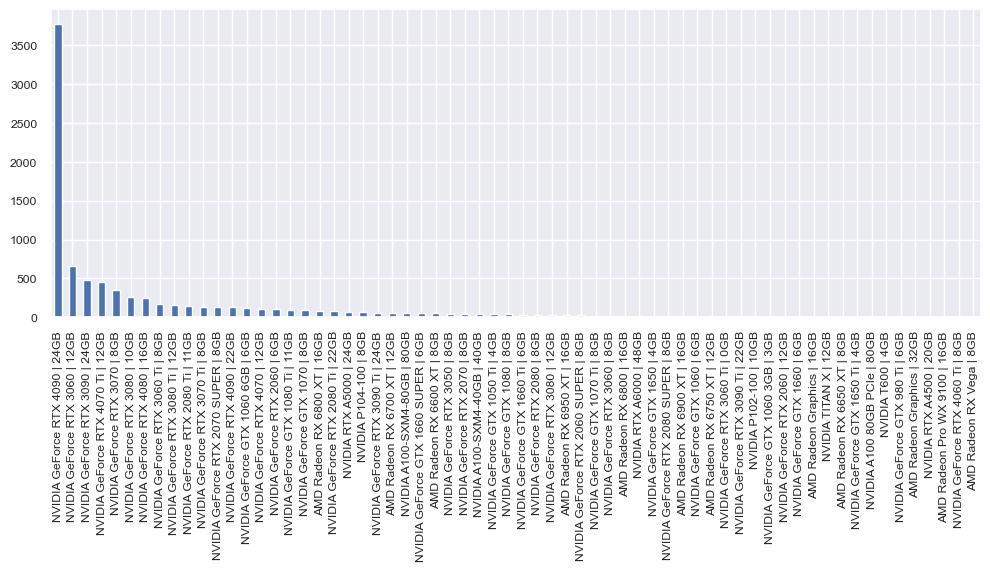

In [354]:
sns.set(font_scale=0.8)
ax = df_res3.device.value_counts().plot.bar(figsize=(12,4))
sns.set(font_scale=1)

Identify worst performers

In [355]:
df_res3[['device','best_score']].groupby('device').max().sort_values('best_score')[:10]

,best_score
device,
NVIDIA GeForce GTX 1650 Ti | 4GB,0.35
NVIDIA GeForce GTX 1650 | 4GB,0.53
NVIDIA T600 | 4GB,0.65
NVIDIA GeForce GTX 1050 Ti | 4GB,1.04
NVIDIA GeForce GTX 1060 3GB | 3GB,1.23
NVIDIA GeForce GTX 1060 | 6GB,1.33
NVIDIA GeForce GTX 1660 | 6GB,1.60
NVIDIA GeForce GTX 1060 6GB | 6GB,1.83
AMD Radeon Pro WX 9100 | 16GB,1.86


Review data for irregular models that should have 24GB ram but report 22 RAM.

In [356]:
df_res3[df_res3.device == "NVIDIA GeForce RTX 3090 Ti | 22GB"][['device','user','best_score']].head()

,device,user,best_score
6845,NVIDIA GeForce RTX 3090 Ti | 22GB,mycon,18.62
6846,NVIDIA GeForce RTX 3090 Ti | 22GB,mycon,20.92
6847,NVIDIA GeForce RTX 3090 Ti | 22GB,mycon,19.51
6848,NVIDIA GeForce RTX 3090 Ti | 22GB,mycon,20.92
6849,NVIDIA GeForce RTX 3090 Ti | 22GB,mycon,19.51


They seem to come from the same user.

In [357]:
df_res3[df_res3.device == "NVIDIA GeForce RTX 4090 | 22GB"][['device','user','best_score']].head()

,device,user,best_score
279,NVIDIA GeForce RTX 4090 | 22GB,cloud,13.89
1173,NVIDIA GeForce RTX 4090 | 22GB,NoInternet,41.58
1225,NVIDIA GeForce RTX 4090 | 22GB,zi_zi,35.69
1226,NVIDIA GeForce RTX 4090 | 22GB,zi_zi,39.72
1227,NVIDIA GeForce RTX 4090 | 22GB,zi_zi,39.24


I will now manually blacklist some cards that I believe should be out of scope.

- We are removing the 3090 22GB and 4090 22GB as these show considerably worse performance.
These cards should come with 24GB, and it seems some ECC options lowers memory to 22GB (and worsens performance)

In [358]:
gpu_blacklist = [
    "AMD Radeon Graphics | 16GB",
    "AMD Radeon Graphics | 32GB",
    "AMD Radeon Pro WX 9100 | 16GB",
    "NVIDIA A100 80GB PCIe | 80GB",
    "NVIDIA A100-SXM4-40GB | 40GB",
    "NVIDIA A100-SXM4-80GB | 80GB",
    "NVIDIA GeForce GTX 1050 Ti | 4GB",
    "NVIDIA GeForce GTX 1070 | 8GB",
    "NVIDIA GeForce GTX 1070 Ti | 8GB",
    "NVIDIA GeForce GTX 1650 | 4GB",
    "NVIDIA GeForce GTX 1650 Ti | 4GB",
    "NVIDIA GeForce GTX 1660 | 6GB",
    "NVIDIA GeForce GTX 1660 Ti | 6GB",
    "NVIDIA GeForce RTX 3060 Ti | 0GB",
    "NVIDIA GeForce RTX 3090 Ti | 22GB",
    "NVIDIA GeForce RTX 4090 | 22GB",
    "NVIDIA P102-100 | 10GB",
    "NVIDIA P104-100 | 8GB",
    "NVIDIA RTX A4500 | 20GB",
    "NVIDIA RTX A5000 | 24GB",
    "NVIDIA RTX A6000 | 48GB",
    "NVIDIA T600 | 4GB",
    "NVIDIA TITAN X | 12GB"
]

mask = df_res3.device.isin(gpu_blacklist)
print(df_res3.device.nunique())

df_res4 = df_res3[~mask]
print(df_res4.device.nunique())

64
41


Unify records for the 3060 as there two name variations for the same card. Likely an error.

In [359]:
map_3060 = {"NVIDIA GeForce GTX 1060 6GB | 6GB": "NVIDIA GeForce GTX 1060 | 6GB"}
print(df_res4[df_res4.device == "NVIDIA GeForce GTX 1060 6GB | 6GB"].shape[0])
print(df_res4[df_res4.device == "NVIDIA GeForce GTX 1060 | 6GB"].shape[0])
mask = df_res4.device == "NVIDIA GeForce GTX 1060 6GB | 6GB"
df_res4.device.replace(map_3060, inplace=True)

records = df_res4.device.value_counts()['NVIDIA GeForce GTX 1060 | 6GB']
print(f"Total records for GTX 1060 6GB after consolidation:  {records}")

118
16
Total records for GTX 1060 6GB after consolidation:  134


Simplify device labels so the chart is more readable

Each benchmark comes with 5 scores, for batch size 1, 2, 4, 8, 16.
Since we are interested in identifying a card by it's maximum potential performance across batch size configuration, we go with the max score across these scores from an individual benchmark.

We plotted for each card,

1. Average performance across benchmarks from the maximum score per benchmark
2. Maximum performance across benchmarks from the maximum score per benchmark

We believe that the #1 offer the most meaningful insighs for our interest, as they represent the average of the best scores that the testers were able to achieve on their cards.

In [360]:
df_res4['device'] = df_res4['device'].str.replace(r'(GeForce|Radeon|RTX|GTX|RX) ', '', regex=True)
mask_4090 = df_res4.device == 'NVIDIA 4090 | 24GB'


### 1. Average performance across benchmarks from the maximum score per benchmark


Plot bars horizontally for better readibility

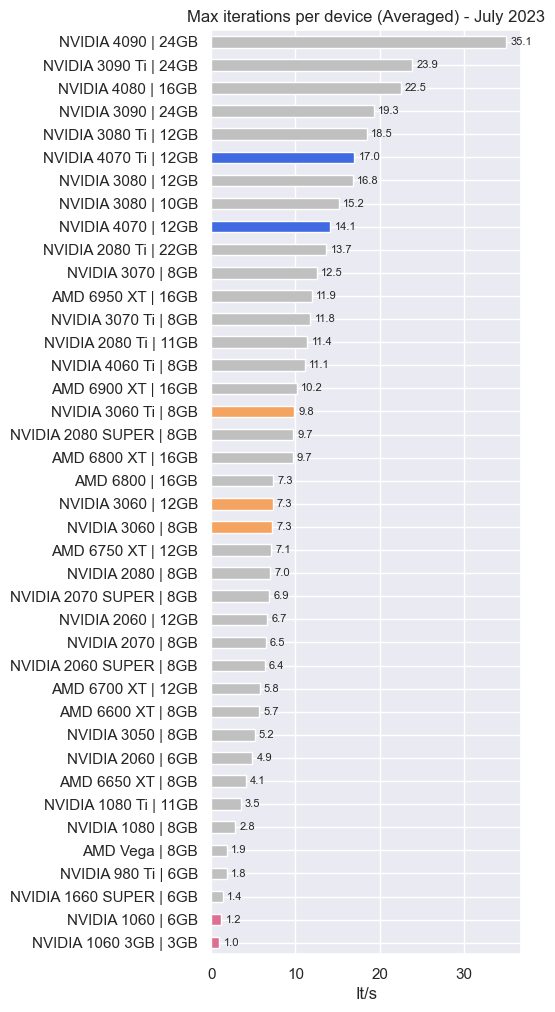

In [361]:
mbs_gr = df_res4.groupby(by='device')['best_score'].mean().reset_index().sort_values('best_score', ascending=True)

# mbs_gr['colors'] = mbs_gr.apply(lambda x : 'sandybrown' if '3060' in x.device else 'mediumslateblue', axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'sandybrown' if '3060' in x.device else 'silver', axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'palevioletred' if '1060' in x.device else x.colors, axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'royalblue' if '4070' in x.device else x.colors, axis=1)

ax = mbs_gr.plot.barh(x='device',y='best_score',figsize=(4,12), color=mbs_gr['colors'], legend=False)

title = 'Max iterations per device (Averaged) - July 2023'
labels = ax.set(ylabel=None, xlabel='It/s', title=title)
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
annotations = ax.bar_label(ax.containers[0], fmt='%.1f', padding=3, fontsize=8)

plt.savefig(f"{title}.png", bbox_inches='tight')

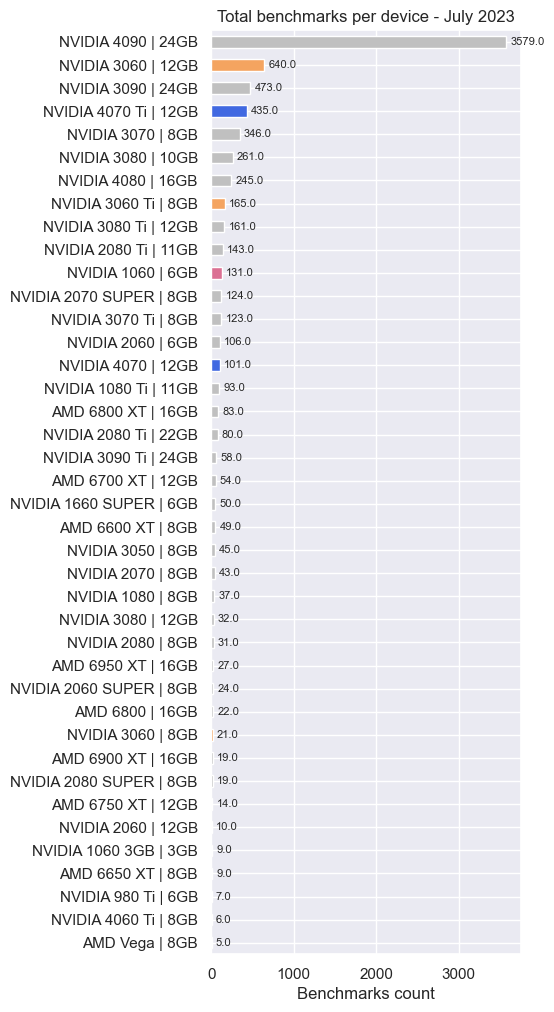

In [362]:
mbs_gr = df_res4.groupby(by='device')['best_score'].count().reset_index().sort_values('best_score', ascending=True)

# mbs_gr['colors'] = mbs_gr.apply(lambda x : 'sandybrown' if '3060' in x.device else 'mediumslateblue', axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'sandybrown' if '3060' in x.device else 'silver', axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'palevioletred' if '1060' in x.device else x.colors, axis=1)
mbs_gr['colors'] = mbs_gr.apply(lambda x : 'royalblue' if '4070' in x.device else x.colors, axis=1)

ax = mbs_gr.plot.barh(x='device',y='best_score',figsize=(4,12), color=mbs_gr['colors'], legend=False)

title = 'Total benchmarks per device - July 2023'
labels = ax.set(ylabel=None, xlabel='Benchmarks count', title=title)
annotations = ax.bar_label(ax.containers[0], fmt='%.1f', padding=3, fontsize=8)

plt.savefig(f"{title}.png", bbox_inches='tight')

### 2. Maximum performance across benchmarks from the maximum score per benchmark

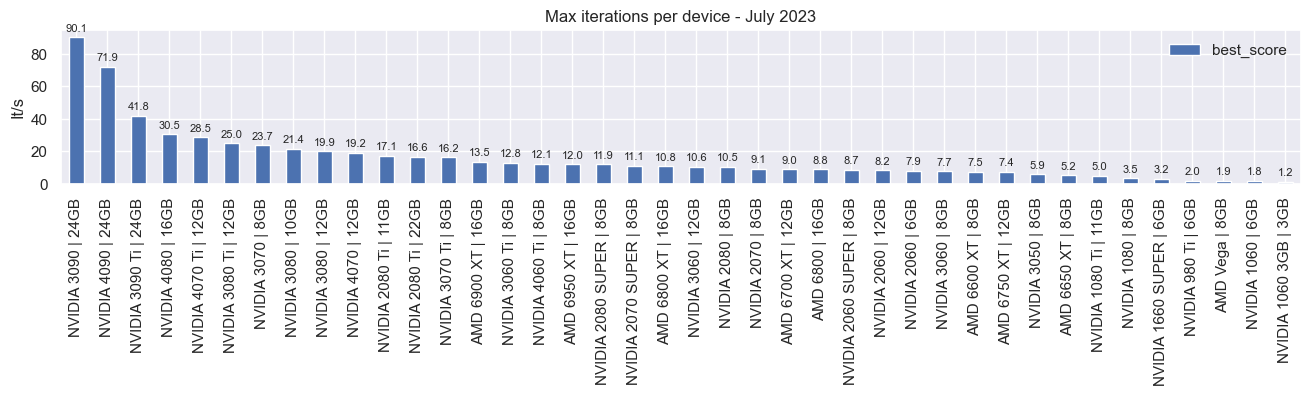

In [363]:
ax = df_res4.groupby(by='device')['best_score'].max().reset_index().sort_values('best_score', ascending=False).plot.bar(x='device',y='best_score',figsize=(16,2))
# ax = df_res4[~mask_4090].device.value_counts(ascending=True).plot.barh()
# ax = df_res4[~mask_4090].groupby(by='device')['best_score'].max().reset_index().sort_values('best_score', ascending=False).plot.bar(x='device',y='best_score',figsize=(14,2))
# plt.figure(figsize=(16,2))

title = 'Max iterations per device - July 2023'
labels = ax.set(xlabel=None, ylabel='It/s', title=title)
annotations = ax.bar_label(ax.containers[0], fmt='%.1f', padding=3, fontsize=8)
plt.savefig(f"{title}.png", bbox_inches='tight')

# Analysis for performance vs price

Load price data and visualize price per GPU

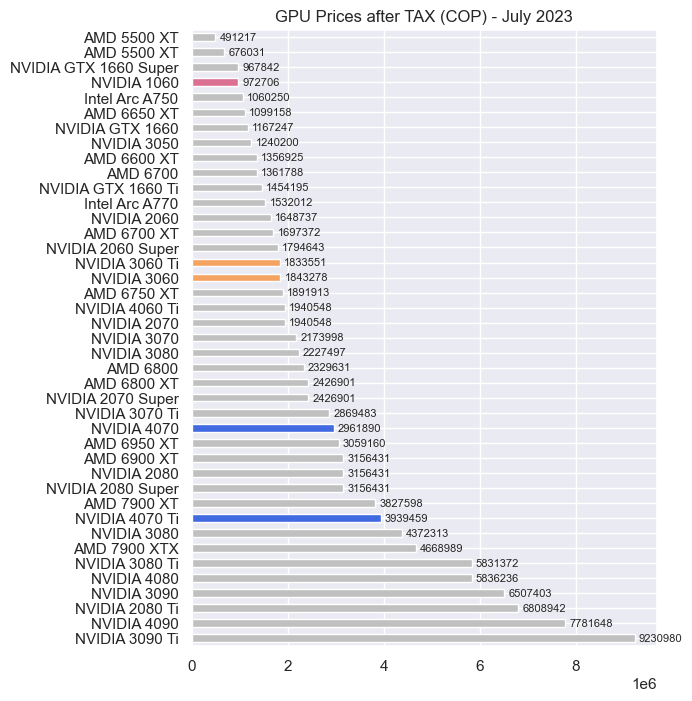

In [364]:
trm = 4087
import_tax = 1.19

prices_df = pd.read_csv('./prices.csv')
prices_df.columns = ['device', 'ram', 'price_dollars']
prices_df['price_cop'] = trm * prices_df['price_dollars']
prices_df['price_cop_after_tax'] = prices_df['price_cop'] * import_tax
prices_df.sort_values('price_dollars', ascending=False, inplace=True)
prices_df.set_index('device', inplace=True)

prices_df['colors'] = prices_df.apply(lambda x : 'sandybrown' if '3060' in x.name else 'silver', axis=1)
prices_df['colors'] = prices_df.apply(lambda x : 'palevioletred' if '1060' in x.name else x.colors, axis=1)
prices_df['colors'] = prices_df.apply(lambda x : 'royalblue' if '4070' in x.name else x.colors, axis=1)

ax = prices_df['price_cop_after_tax'].plot.barh(figsize=(6,8), color=prices_df['colors'], legend=False)
title = 'GPU Prices after TAX (COP) - July 2023'
labels = ax.set(ylabel=None, xlabel=None, title=title)
annotations = ax.bar_label(ax.containers[0], fmt='%.0f', padding=3, fontsize=8)
plt.savefig(f"{title}.png", bbox_inches='tight')

Merge price and benchmarks data to get performance / price ratio.

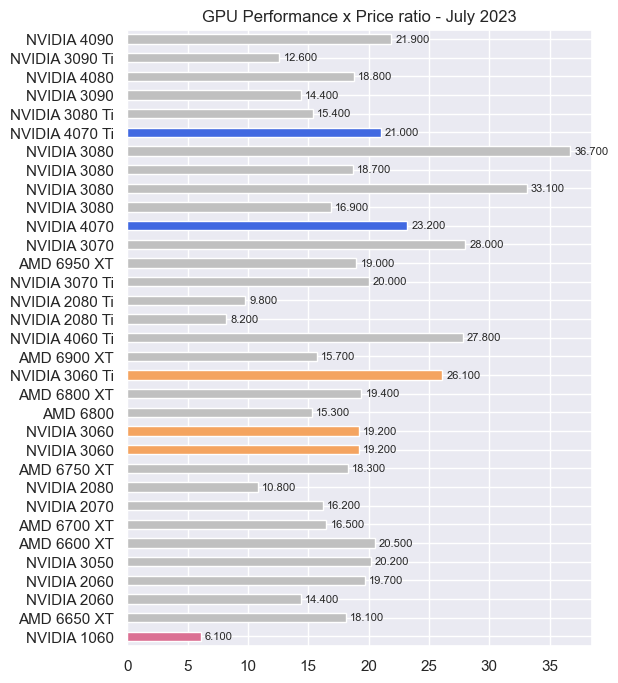

In [365]:
mbs_gr = df_res4.groupby(by='device')['best_score'].mean().reset_index().sort_values('best_score', ascending=True)


labels = mbs_gr.device.apply(lambda x: x.split('|')[0].strip())
labels.name = 'device2'
df_res5 = pd.concat([mbs_gr, labels], axis=1)
df_res5.drop(columns=['device'], inplace=True)
df_res5.set_index('device2', inplace=True)
df_res5.index.name = 'device'

df_res5 = df_res5.merge(prices_df, how='inner', on='device')
df_res5['colors'] = df_res5.apply(lambda x : 'sandybrown' if '3060' in x.name else 'silver', axis=1)
df_res5['colors'] = df_res5.apply(lambda x : 'palevioletred' if '1060' in x.name else x.colors, axis=1)
df_res5['colors'] = df_res5.apply(lambda x : 'royalblue' if '4070' in x.name else x.colors, axis=1)

df_res5.head()
df_res5['ratio_pf_price'] =  (df_res5.best_score / df_res5.price_dollars).round(4) *1000

ax = df_res5.plot.barh(y='ratio_pf_price', figsize=(6,8), color=df_res5['colors'], legend=False)
title = 'GPU Performance x Price ratio - July 2023'
labels = ax.set(ylabel=None, xlabel=None, title=title)
annotations = ax.bar_label(ax.containers[0], fmt='%.3f', padding=3, fontsize=8)
plt.savefig(f"{title}.png", bbox_inches='tight')


Visualize performance to price ratio per GPU with color scaled based off price.
We will be using plotly for interactive charts.

In [366]:
# Setup plotly

import kaleido
# Set up pandas to use plotly
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"

# Bring plotly for direct use
import plotly.express as px

In [367]:
df_res5 = df_res4.groupby(by='device')['best_score'].mean().reset_index().sort_values('best_score', ascending=True)
df_res5.set_index('device', inplace=True)
prices_df.index = prices_df.index + ' | ' + prices_df['ram']

df_res5 = df_res5.merge(prices_df, how='inner', left_index=True, right_index=True)
df_res5['colors'] = df_res5.apply(lambda x : 'sandybrown' if '3060' in x.name else 'silver', axis=1)
df_res5['colors'] = df_res5.apply(lambda x : 'palevioletred' if '1060' in x.name else x.colors, axis=1)
df_res5['colors'] = df_res5.apply(lambda x : 'royalblue' if '4070' in x.name else x.colors, axis=1)

df_res5['ratio_pf_price'] =  (df_res5.best_score / df_res5.price_dollars).round(4) *1000

title = 'Performance to price ratio (higher is better) - 512x512 Gens'
fig = px.bar(df_res5, y=df_res5.index, x='ratio_pf_price', orientation='h', color="price_dollars",  text_auto=True, color_continuous_scale ='darkmint', opacity=1)
fig.update_layout(
    legend=dict(yanchor="top", y=0.9, xanchor="left", x=1.2), 
    yaxis_title='GPU', 
    title=title,
    xaxis_title='Ratio',
    width=1000,
    height=900,
    yaxis={'categoryorder': 'total ascending'},
    margin = dict(l = 200, r =100, b = 100, t = 100)
)
fig.update_yaxes(ticksuffix = "  ")
fig.write_image(f"{title}.png")

fig.show()


Visualize Iterations per second per GPU with color scaled based off price.

In [368]:
title = 'Iterations per second (higher is better) - 512x512 Gens'
fig = px.bar(df_res5, y=df_res5.index, x='best_score', orientation='h', color="price_dollars",  text_auto=True, color_continuous_scale ='darkmint', opacity=1)
fig.update_layout(
    legend=dict(yanchor="top", y=0.9, xanchor="left", x=1.2), 
    yaxis_title='GPU', 
    title=title,
    xaxis_title='Ratio',
    width=1000,
    height=900,
    yaxis={'categoryorder': 'total ascending'},    
    margin = dict(l = 200, r =100, b = 100, t = 100)
)
fig.update_yaxes(ticksuffix = "  ")
fig.write_image(f"{title}.png", scale=2.0)

fig.show()

Visualize seconds to generate an 512x512 image with 25 steps

In [369]:
title = 'Seconds per image (lower is better) - 512x512 Gens'
steps_per_image = 25
df_res5['imgs_s'] = (1 / (df_res5['best_score'] / steps_per_image)).round(2)

fig = px.bar(df_res5, y=df_res5.index, x='imgs_s', orientation='h', color="price_dollars",  text_auto=True, color_continuous_scale ='darkmint', opacity=1)
fig.update_layout(
    legend=dict(yanchor="top", y=0.9, xanchor="left", x=1.2), 
    yaxis_title='GPU', 
    title=title,
    xaxis_title='Ratio',
    width=1000,
    height=900,
    yaxis={'categoryorder': 'total descending'},    
    margin = dict(l = 200, r =100, b = 100, t = 100)
)
fig.update_yaxes(ticksuffix = "  ")
fig.write_image(f"{title}.png", scale=2.0)
fig.show()

Export results to csv

In [370]:
combined = df_res5.drop(columns='colors')
combined.to_csv('combined_results.csv')

# Works by other authors:

Youtube - [The Best Price To Performance Gpu For Stable Diffusion | Best Stable Diffusion Gpu](https://www.youtube.com/watch?v=XfiS7Taeaww)

Youtube - [What GPU do I need for Stable Diffusion? GPU / Graphics card Performance Benchmark](https://www.youtube.com/watch?v=glCGnCvUox4)

Youtube - [Choose the Best Graphics Card for Stable Diffusion](https://www.youtube.com/watch?v=L1oL-kI12Yw)


# Conclusion

In this analysis, we examined data collected by the SD WebUI Extension from users of the A1111 WebUI, which is gathered automatically through **crowdsourcing**.

We calculated a ratio of performance (measured in iterations per second) to price to represent the value of each GPU card. This metric, often referred to as “value,” takes into account both the performance and cost of each card.

Our goal was to identify the optimal GPU card for stable diffusion that offers the most value per dollar. However, it’s important to note that value is a relative measure and depends on how the card will be used. For example, even older cards like the GTX 1060 can successfully run A1111 WebUI. The main advantage of newer cards is the time saved to generate content.

For those considering purchasing a GPU card, we suggest considering **two purchase criteria**:

- How much is your time worth? Does the time saved with a faster card justify the cost?
- How much are you willing to pay per month for the features offered by the card? If you plan to use the card for 5 years, does the GPU cost cancels out with the amount you would otherwise spend on a third service that provides those features?